# SAE Training Example

## Adding src to sys.path for imports

In [ ]:
import sys
import os
#os.chdir("AstroBio")
sys.path.append("./src")



## Imports

In [3]:
import torch
import scanpy as sc
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam

# local
from src.models import SparseAutoencoder
from src.dataset import EmbeddingDataset


## Load scanpy object

In [5]:
adata = sc.read_h5ad("./data/external/adata_sample.h5ad")
embeddings_data = adata.obsm["geneformer"]

## Create Datasets

In [10]:
dset = EmbeddingDataset(embeddings_data)
train_dataset, test_dataset = random_split(dset, [0.8, 0.2])

In [11]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Training the Model

Training: 100%|██████████| 100/100 [00:17<00:00,  5.63it/s, Train Loss=0.0034, Test Loss=0.0047, Train Recon=0.0031, Test Recon=0.0044]


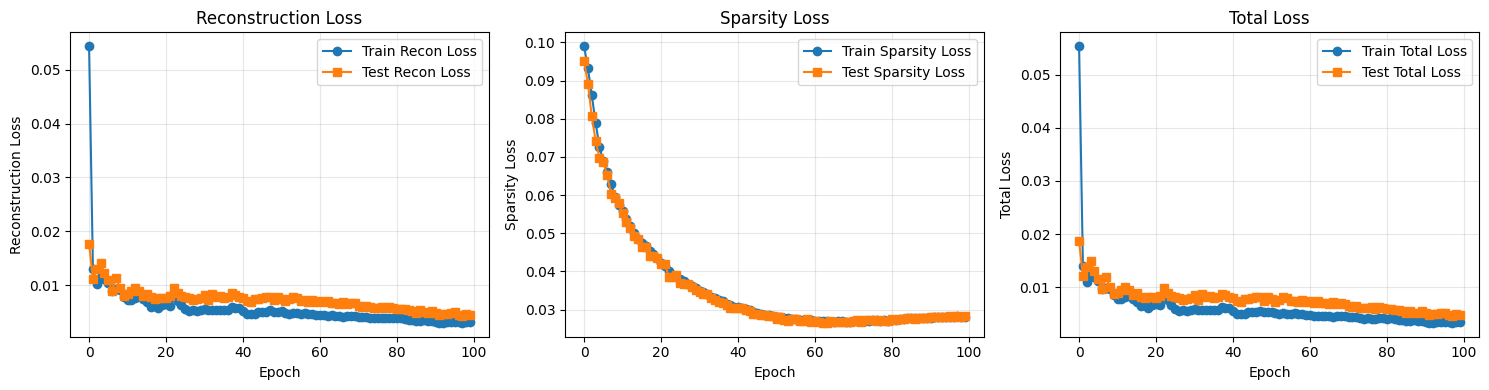

In [13]:
model = SparseAutoencoder(input_dim=512,hidden_dim=1028, expanded_ratio=4.0)
losses = model.train_model(
    train_loader=train_loader,
    test_loader=test_loader,
    n_epochs=100,
    lr=1e-3,
    sparsity_weight=1e-2,
    
)

In [ ]:
n_epoches = 1

optimizer = Adam(model.parameters(), lr=1e-3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
model.train()

for i_epoch in range(n_epoches):
    for i_step, d in enumerate(train_loader):
        d = d.to(device)
        optimizer.zero_grad()
        recon, embed = model(d)
        recon_loss, sparsity_loss, total_loss = model.get_total_loss(d, recon, embed, sparsity_weight=1e-2)
        total_loss.backward()
        optimizer.step()

        if i_step % 100:
            model.eval()
            for test_d in test_loader:
                test_d = test_d.to(device)
                with torch.no_grad():
                    test_recon, test_embed = model(test_d)  
                    test_recon_loss, test_sparsity_loss, test_total_loss = model.get_total_loss(test_d, test_recon, test_embed, sparsity_weight=1e-2)
                    print(f"epoches {i_epoch}, steps {i_step}, loss (recon_loss): {test_recon_loss.item()}, loss (sparsity): {test_sparsity_loss.item()}, loss (total): {test_total_loss.item()}")
            model.train()